# Load libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
fastai.show_install()



```text
=== Software === 
python version : 3.6.6
fastai version : 1.0.29.dev0
torch version  : 1.0.0.dev20181002
torch cuda ver 
torch cuda is  : **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform       : Darwin-18.2.0-x86_64-i386-64bit
conda env      : base
python         : /Users/janmarais/anaconda3/envs/fastaiv1/bin/python
sys.path       : 
/Users/janmarais/anaconda3/envs/fastaiv1/lib/python36.zip
/Users/janmarais/anaconda3/envs/fastaiv1/lib/python3.6
/Users/janmarais/anaconda3/envs/fastaiv1/lib/python3.6/lib-dynload
/Users/janmarais/anaconda3/envs/fastaiv1/lib/python3.6/site-packages
/Users/janmarais/workspace/repos/fastai
/Users/janmarais/anaconda3/envs/fastaiv1/lib/python3.6/site-packages/IPython/extensions
/Users/janmarais/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



In [4]:
from fastai import *
from fastai.tabular import *
from sklearn.model_selection import train_test_split, KFold

from model import tabular_learner
from fastai.callbacks import CSVLogger
import sympy

ModuleNotFoundError: No module named 'sympy'

# Experiments utilities

In [5]:
def get_config_df(config):
    df = pd.DataFrame(list(itertools.product(*config.values())), columns=config.keys())
    df.index = [f'model_{i+1}' for i in range(len(df))]
    return df

In [6]:
def create_experiment(nm, path, folder='results'):
    exp_path = (path/folder/nm)
    exp_path.mkdir(exist_ok=True)
    return nm, exp_path

def record_experiment(learn, fn):
    learn.callback_fns.append(partial(CSVLogger, filename=exp_path/fn))

In [7]:
def load_results(exp_path):
    config_df = pd.read_csv(exp_path/'config.csv', index_col=0)
    param_names = config_df.columns.values
    recorder_df=[]
    for p in exp_path.ls():
        if p.name.startswith(tuple(config_df.index.values)):
            df = pd.read_csv(p)
            ind_name, fold_name = p.stem.split('-')
            df['index']=ind_name
            df['fold']=int(fold_name.split('_')[-1].split('.')[0])
            recorder_df.append(df)
    recorder_df = pd.concat(recorder_df)
    metric_names = list(set(recorder_df.columns).symmetric_difference(['index', 'epoch', 'train_loss', 'fold']))
    recorder_df = recorder_df.merge(config_df.reset_index())
    return config_df, recorder_df, param_names, metric_names

def summarise_results(recorder_df, param_names, metric_names):
    return (recorder_df.groupby(['index', *param_names, 'epoch'], as_index=False)
            .agg({k:['mean', 'std'] for k in metric_names}))

In [8]:
def plot_best(summary_df, param_names, metric_names, ylim1=None, ylim2=None):
    mean_df = (summary_df.groupby(['index']).tail(1)
               .pivot(index=param_names[0], columns=param_names[1], 
                      values=[(metric_names[0], 'mean'), (metric_names[1], 'mean')]))
    sigma_df = (summary_df.groupby(['index']).tail(1)
                .pivot(index=param_names[0], columns=param_names[1], 
                       values=[(metric_names[0], 'std'), (metric_names[1], 'std')]))

    fig, ax = plt.subplots(1, len(metric_names), figsize=(20,6))
    for i, met in enumerate(metric_names):
        mu = mean_df[((met, 'mean'),)]
        sigma = sigma_df[((met, 'std'),)]
        for j in range(mu.shape[1]):
            ax[i].plot(mu.iloc[:,j], label=mu.columns[j])
            ax[i].fill_between(mu.index, mu.iloc[:,j]-sigma.iloc[:,j], mu.iloc[:,j]+sigma.iloc[:,j], alpha=0.3)
            ax[i].set_ylabel(met)
            ax[i].set_xlabel(mu.index.name)
            ax[i].legend(title=param_names[1])
            ax[i].set_xticks(mu.index)
    if ylim1: ax[0].set_ylim(ylim1)
    if ylim2: ax[1].set_ylim(ylim2)

In [9]:
def plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=None, ylim2=None):
    mean_df = summary_df.pivot(index='epoch', columns='index', 
                               values=[(metric_names[0], 'mean'), (metric_names[1], 'mean')])
    sigma_df = summary_df.pivot(index='epoch', columns='index', 
                                values=[(metric_names[0], 'std'), (metric_names[1], 'std')])

    fig, ax = plt.subplots(1, len(metric_names), figsize=(20,6))
    for i, met in enumerate(metric_names):
        mu = mean_df[((met, 'mean'),)]
        sigma = sigma_df[((met, 'std'),)]
        for j in range(mu.shape[1]):
            ax[i].plot(mu.iloc[:,j], label=f"({','.join([str(p) for p in config_df.loc[mu.columns[j]]])})")
            ax[i].fill_between(mu.index, mu.iloc[:,j]-sigma.iloc[:,j], mu.iloc[:,j]+sigma.iloc[:,j], alpha=0.3)
            ax[i].set_ylabel(met)
            ax[i].set_xlabel(mu.index.name)
            ax[i].legend(title=f"({','.join(param_names)})")
            ax[i].set_xticks(mu.index)
    if ylim1: ax[0].set_ylim(ylim1)
    if ylim2: ax[1].set_ylim(ylim2)

# Read in Data

In [10]:
path = Path('../data')

In [11]:
df = pd.read_csv('../data/adult.csv')

In [12]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>=50k
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,1
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,1
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,0


# Preprocessing

## Define column types

In [13]:
dep_var = '>=50k'
num_vars = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

In [14]:
df = df.loc[:, num_vars+cat_vars+[dep_var]]

In [15]:
df.shape

(32561, 15)

## Global Parameters

In [16]:
bs=256

procs = [FillMissing, Categorify, Normalize]

kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Validating

In [74]:
_, valid_ids = next(kf.split(df))

In [75]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

data = (src.split_by_idx(valid_ids)
        .label_from_df(cols=dep_var)
        .databunch(bs=bs))

In [82]:
learn = tabular_learner(data, layers=[200,200], act_func='selu', residual=True, mixup_aug=True, 
                        metrics=accuracy, callback_fns=[partial(CSVLogger, filename='temp.csv')])

In [77]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(5, 1e-3)

Total time: 01:28
epoch  train_loss  valid_loss  accuracy
1      0.451558    0.377077    0.828804  (00:17)
2      0.435567    0.376025    0.829418  (00:17)
3      0.438344    0.360038    0.838170  (00:17)
4      0.429486    0.352548    0.839705  (00:17)
5      0.424058    0.352655    0.839091  (00:17)



# Test experiment

In [15]:
experiment_name, exp_path = create_experiment('test', path)

In [153]:
config={'n_layers':[1,2], 'layer_size':[32,64]}
config_df = get_config_df(config)

In [163]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [164]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=bs))

        learn = tabular_learner(data, layers=[params['layer_size']]*params['n_layers'], metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(2, 1e-2)

Total time: 00:19
epoch  train_loss  valid_loss  accuracy
1      0.369093    0.350764    0.839681  (00:09)
2      0.371728    0.347857    0.841063  (00:09)



In [25]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

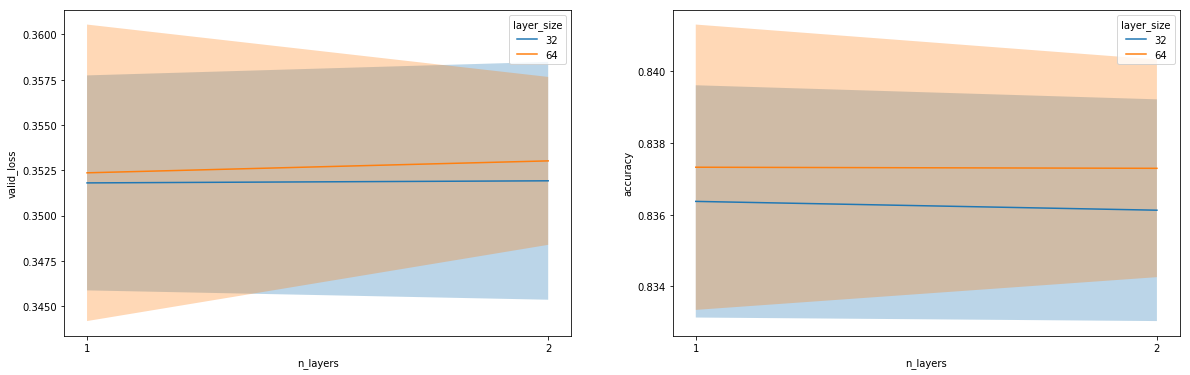

In [26]:
plot_best(summary_df, param_names, metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

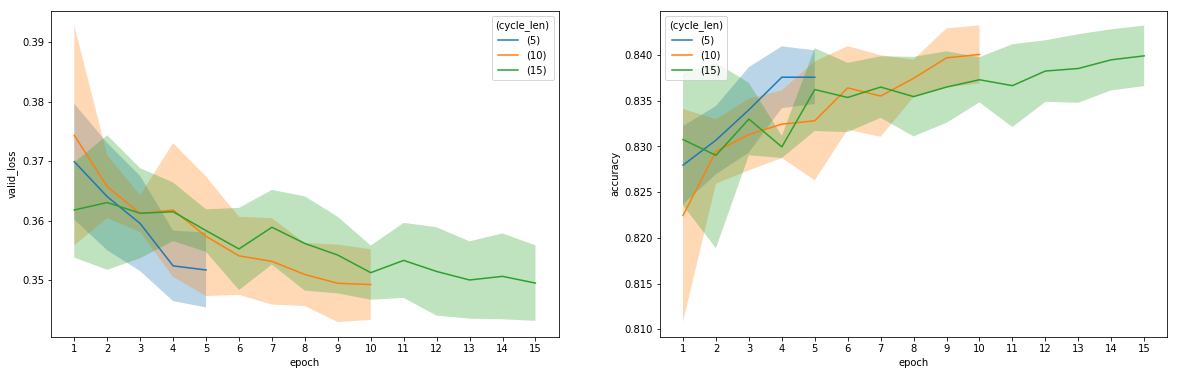

In [34]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# 1Cycle

In [59]:
experiment_name, exp_path = create_experiment('onecycle_batchsize', path)

In [35]:
config={'cycle_len':[5,10,20], 'batch_size':[64,256,1024]}
config_df = get_config_df(config)

In [36]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [37]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=int(params['batch_size'])))

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(params['cycle_len'], 1e-2)

Total time: 00:13
epoch  train_loss  valid_loss  accuracy
1      0.581817    0.635188    0.803133  (00:00)
2      0.494004    0.421146    0.806511  (00:00)
3      0.424890    0.366612    0.824324  (00:00)
4      0.392426    0.352371    0.832002  (00:00)
5      0.376917    0.367902    0.834613  (00:00)
6      0.366896    0.354388    0.829238  (00:00)
7      0.359786    0.352896    0.832617  (00:00)
8      0.356821    0.348270    0.838452  (00:00)
9      0.353085    0.344910    0.837070  (00:00)
10     0.349228    0.345127    0.837224  (00:00)
11     0.346859    0.343187    0.840448  (00:00)
12     0.343357    0.345839    0.838759  (00:00)
13     0.340485    0.354100    0.828931  (00:00)
14     0.337175    0.349769    0.841830  (00:00)
15     0.333308    0.350359    0.838913  (00:00)
16     0.328539    0.354650    0.836609  (00:00)
17     0.324172    0.355272    0.836609  (00:00)
18     0.319596    0.360212    0.833845  (00:00)
19     0.316158    0.361013    0.837377  (00:00)
20     0.31

In [60]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

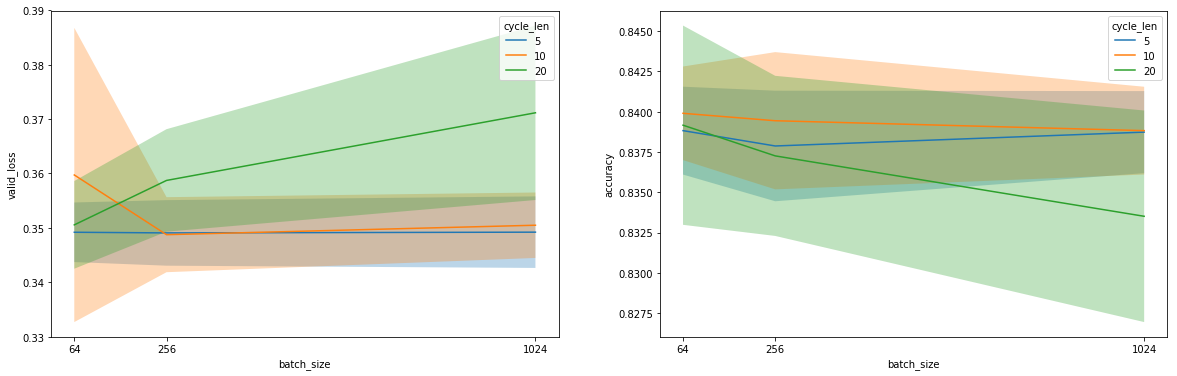

In [41]:
plot_best(summary_df, param_names[::-1], metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

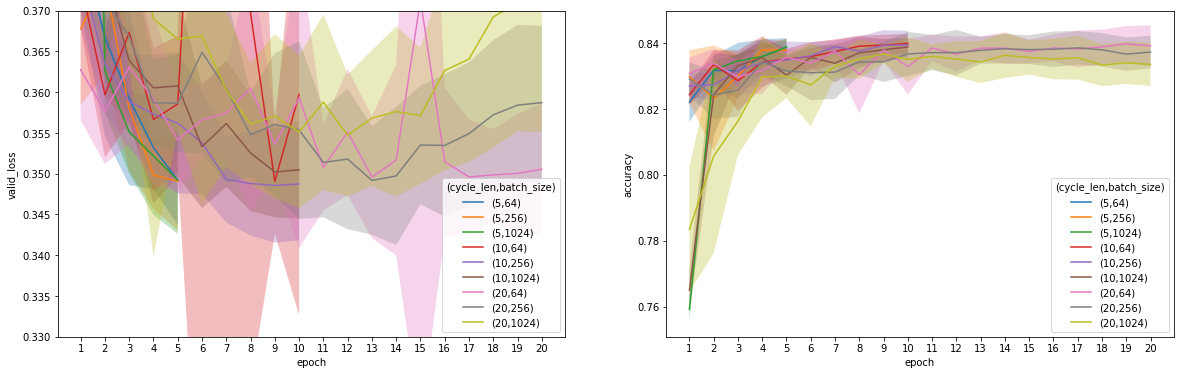

In [61]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.33,0.37))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Number and Size of Layers

In [43]:
experiment_name, exp_path = create_experiment('width_depth', path)

In [44]:
config={'layer_size':[32,128,512,2048], 'n_layer':[1,3,6,12]}
config_df = get_config_df(config)

In [45]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [46]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))

        learn = tabular_learner(data, layers=[params['layer_size']]*params['n_layer'], metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:31
epoch  train_loss  valid_loss  accuracy
1      0.467703    0.464636    0.748618  (00:03)
2      0.400519    0.544364    0.779791  (00:03)
3      0.378785    0.381002    0.833385  (00:03)
4      0.370281    0.480448    0.783170  (00:03)
5      0.365118    0.355163    0.832002  (00:03)
6      0.355501    2.238920    0.840909  (00:03)
7      0.356558    0.369193    0.824324  (00:03)
8      0.351012    0.348861    0.840448  (00:03)
9      0.342926    0.343829    0.841063  (00:03)
10     0.342342    0.345098    0.841370  (00:03)



In [47]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

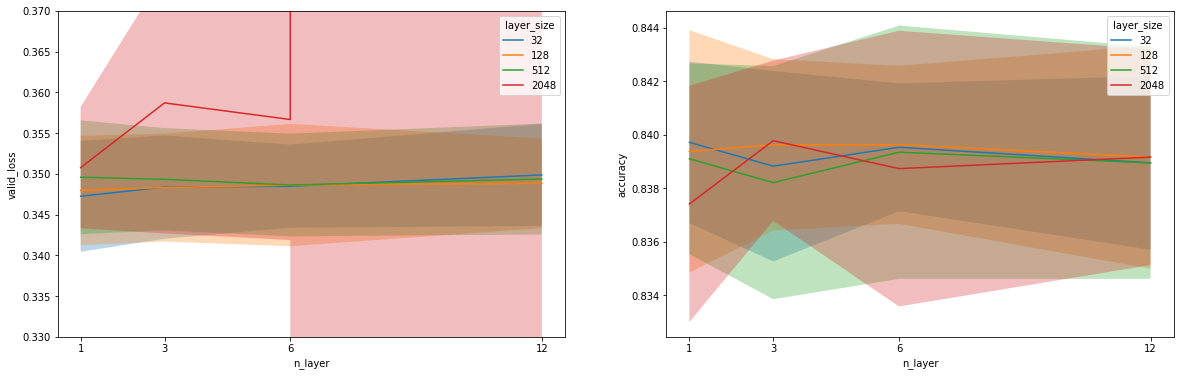

In [57]:
plot_best(summary_df, param_names[::-1], metric_names, ylim1=(0.33,0.37))
plt.savefig(exp_path/'best.png', bbox_inches='tight')

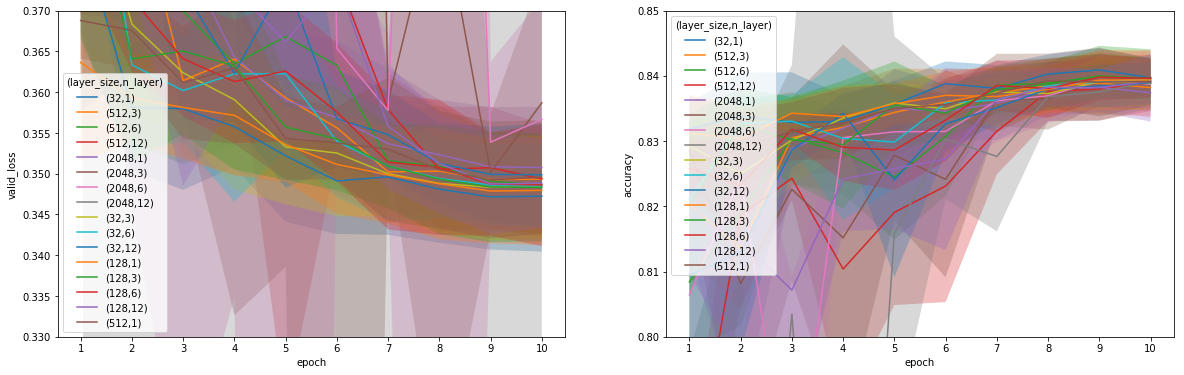

In [58]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.33,0.37), ylim2=(0.8,0.85))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Dropout

In [62]:
experiment_name, exp_path = create_experiment('size_dropout', path)

In [63]:
config={'layer_size':[128,1024], 'dropout':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}
config_df = get_config_df(config)

In [64]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [69]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))

        learn = tabular_learner(data, layers=[int(params['layer_size'])]*3, ps=[params['dropout']]*3, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss  accuracy
1      0.488618    0.377801    0.804361  (00:01)
2      0.425288    0.357577    0.829853  (00:01)
3      0.410701    0.360772    0.831849  (00:01)
4      0.399280    0.356600    0.830160  (00:01)
5      0.381902    0.353214    0.839066  (00:01)
6      0.375233    0.346348    0.836149  (00:01)
7      0.369507    0.346630    0.841830  (00:01)
8      0.363330    0.343923    0.840602  (00:01)
9      0.359405    0.342891    0.837991  (00:01)
10     0.357043    0.342924    0.841677  (00:01)



In [70]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

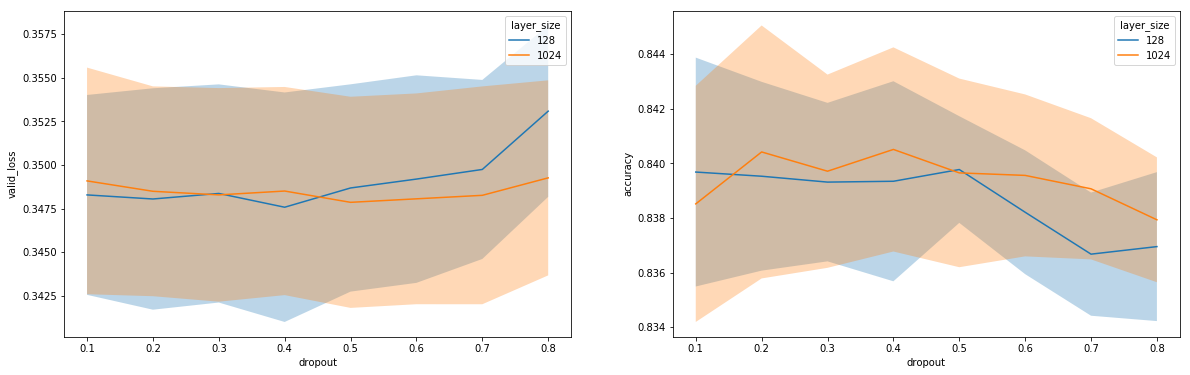

In [71]:
plot_best(summary_df, param_names[::-1], metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

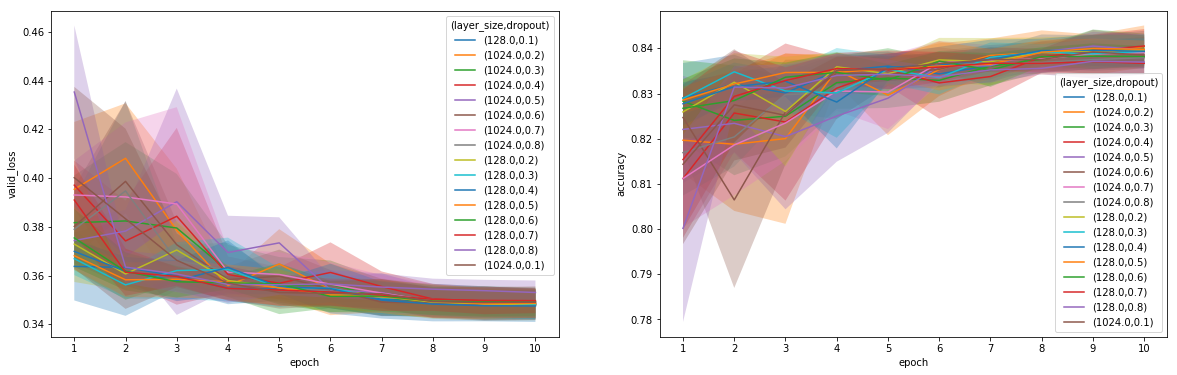

In [72]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Embedding Sizes

In [249]:
def const_emb_rule(r): return r
def prop_emb_rule(n_cat, r): return r*n_cat
def wang_emb_rule(n_cat): return 6*(n_cat)**0.25
def bengio_emb_rule(n_cat): return n_cat/2+1

def my_emb_sz_rule(n_cat, tp='bengio', mx=50, **kwargs): 
    if tp == 'constant': out = const_emb_rule(**kwargs)
    elif tp == 'proportion': out = prop_emb_rule(n_cat, **kwargs)
    elif tp == 'wang': out = wang_emb_rule(n_cat)
    elif tp == 'bengio': out = bengio_emb_rule(n_cat)
    return int(np.clip(out,1,mx))

**Constant**

In [240]:
experiment_name, exp_path = create_experiment('embedding_size', path)

In [241]:
config={'emb_size':[1,2,4,8,16]}
config_df = get_config_df(config)

In [242]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [243]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))
        
        embs = {n:my_emb_sz_rule(len(data.classes[n]),tp='constant',r=params['emb_size']) for n in data.cat_names}
        learn = tabular_learner(data, layers=[256]*2, metrics=accuracy, emb_szs=embs)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:11
epoch  train_loss  valid_loss  accuracy
1      0.392529    0.342082    0.832156  (00:01)
2      0.338166    0.329920    0.844595  (00:01)
3      0.336050    0.316528    0.857647  (00:01)
4      0.329700    0.312528    0.856419  (00:01)
5      0.317804    0.312674    0.856880  (00:01)
6      0.315026    0.309108    0.861179  (00:01)
7      0.308376    0.303714    0.862254  (00:01)
8      0.305198    0.301341    0.862561  (00:01)
9      0.295623    0.302559    0.865018  (00:01)
10     0.290322    0.303310    0.863636  (00:01)



In [244]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [245]:
# plot_best(summary_df, param_names[::-1], metric_names)
# plt.savefig(exp_path/'best.png', bbox_inches='tight')

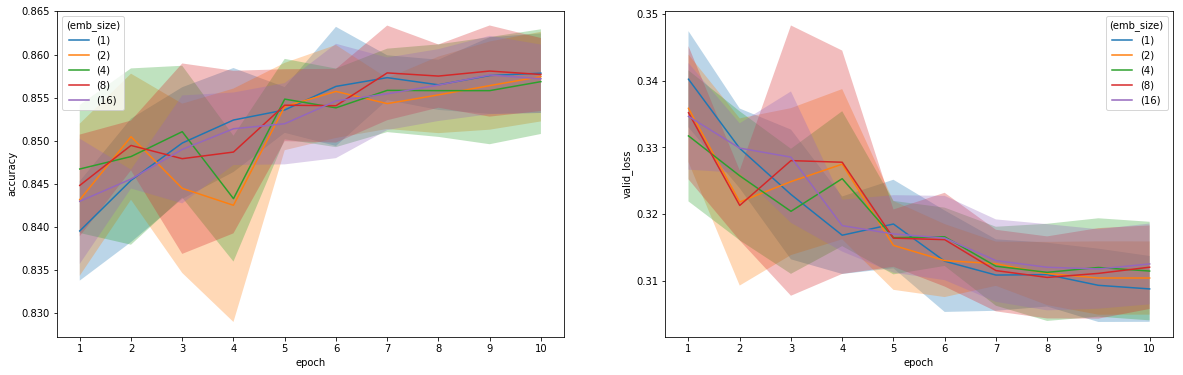

In [246]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

**Proportional**

In [250]:
experiment_name, exp_path = create_experiment('embedding_size_prop', path)

In [251]:
config={'emb_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
config_df = get_config_df(config)

In [252]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [255]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))
        
        embs = {n:my_emb_sz_rule(len(data.classes[n]),tp='proportion',r=params['emb_ratio']) for n in data.cat_names}
        learn = tabular_learner(data, layers=[256]*2, metrics=accuracy, emb_szs=embs)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:12
epoch  train_loss  valid_loss  accuracy
1      0.383513    0.311238    0.856112  (00:01)
2      0.335979    0.321031    0.846591  (00:01)
3      0.331289    0.318557    0.856112  (00:01)
4      0.322870    0.327512    0.836609  (00:01)
5      0.316741    0.316787    0.858108  (00:01)
6      0.316058    0.304341    0.860412  (00:01)
7      0.309103    0.304747    0.861947  (00:01)
8      0.305016    0.305676    0.861179  (00:01)
9      0.292124    0.304449    0.859644  (00:01)
10     0.286467    0.305901    0.858569  (00:01)



In [256]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [245]:
# plot_best(summary_df, param_names[::-1], metric_names)
# plt.savefig(exp_path/'best.png', bbox_inches='tight')

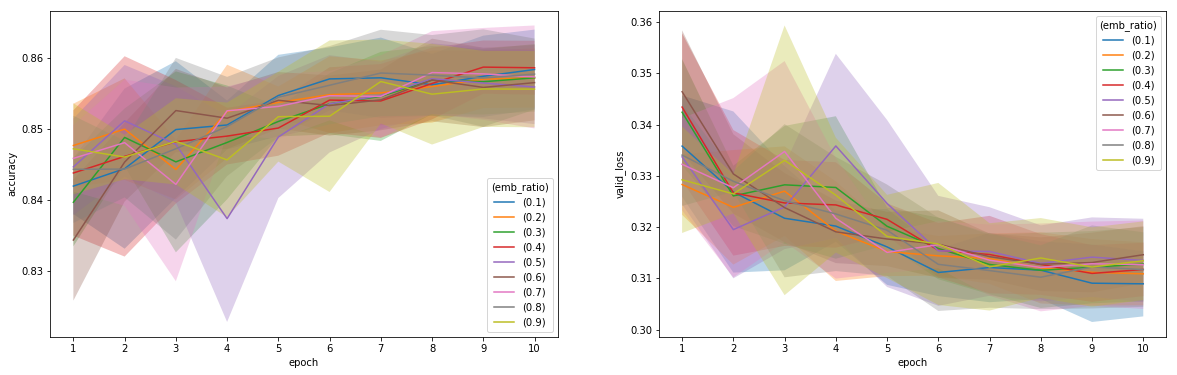

In [257]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Feature Scalings

In [ ]:
class Normalize(TabularProc):
    "Transform the categorical variables to that type."

    def apply_train(self, df:DataFrame):
        self.means,self.stds = {},{}
        for n in self.cont_names:
            self.means[n],self.stds[n] = df.loc[:,n].mean(),df.loc[:,n].std()
            df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])

    def apply_test(self, df:DataFrame):
        for n in self.cont_names:
            df.loc[:,n] = (df.loc[:,n]-self.means[n]) / (1e-7 + self.stds[n])

In [272]:
experiment_name, exp_path = create_experiment('cont_norm', path)

In [273]:
config={'normalise':[True, False]}
config_df = get_config_df(config)

In [274]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    procs = [FillMissing, Categorify]
    if params['normalise']: procs += [Normalize]
    src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))
        
        embs = {n:my_emb_sz_rule(len(data.classes[n]),tp='bengio') for n in data.cat_names}
        learn = tabular_learner(data, layers=[256]*2, metrics=accuracy, emb_szs=embs)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:11
epoch  train_loss  valid_loss  accuracy
1      0.386720    0.317533    0.857187  (00:01)
2      0.332005    0.339412    0.828163  (00:01)
3      0.330229    0.309551    0.860258  (00:01)
4      0.325792    0.314502    0.857801  (00:01)
5      0.319426    0.310965    0.860565  (00:01)
6      0.313942    0.307660    0.861486  (00:01)
7      0.312167    0.305927    0.860565  (00:01)
8      0.306554    0.305233    0.860104  (00:01)
9      0.297408    0.305471    0.862715  (00:01)
10     0.294497    0.306314    0.862254  (00:01)



In [275]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [276]:
# plot_best(summary_df, param_names[::-1], metric_names)
# plt.savefig(exp_path/'best.png', bbox_inches='tight')

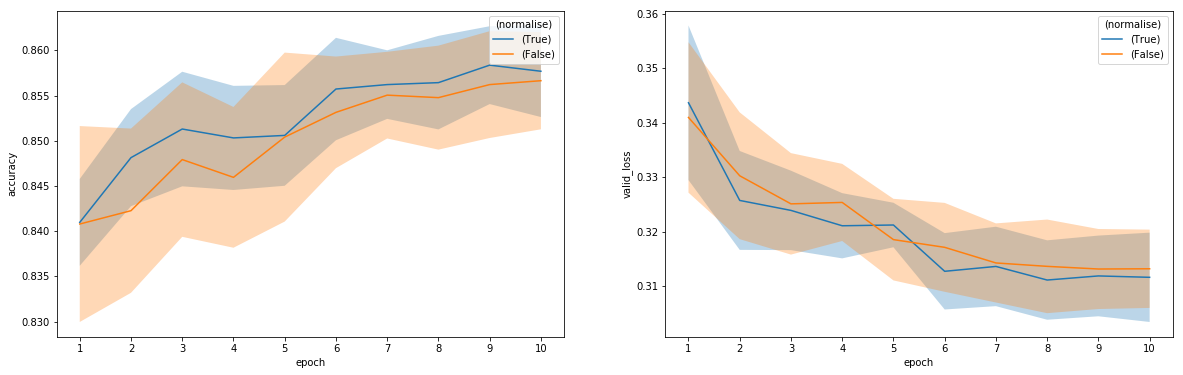

In [277]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

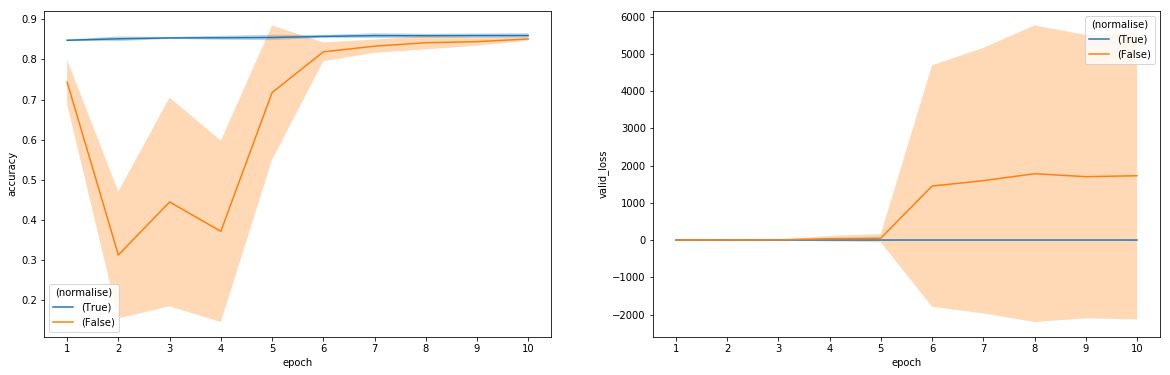

In [270]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Sample Size

In [73]:
experiment_name, exp_path = create_experiment('samplesize', path)

In [74]:
config={'sample_size': [1000,2000,4000,8000,16000,32000]}
config_df = get_config_df(config)

In [75]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    df_sub = df.sample(params['sample_size']).copy()
    src = TabularList.from_df(df_sub, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df_sub)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=64))

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:24
epoch  train_loss  valid_loss  accuracy
1      0.375712    0.362193    0.831563  (00:02)
2      0.369432    0.373252    0.829531  (00:02)
3      0.373782    0.349091    0.839688  (00:02)
4      0.369064    0.353206    0.835938  (00:02)
5      0.361587    0.357971    0.824844  (00:02)
6      0.350354    0.342558    0.843125  (00:02)
7      0.357838    0.344241    0.844688  (00:02)
8      0.335632    0.344441    0.843437  (00:02)
9      0.342440    0.343208    0.844844  (00:02)
10     0.342707    0.343508    0.845469  (00:02)



In [76]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [80]:
# plot_best(summary_df, param_names, metric_names)
# plt.savefig(exp_path/'best.png', bbox_inches='tight')

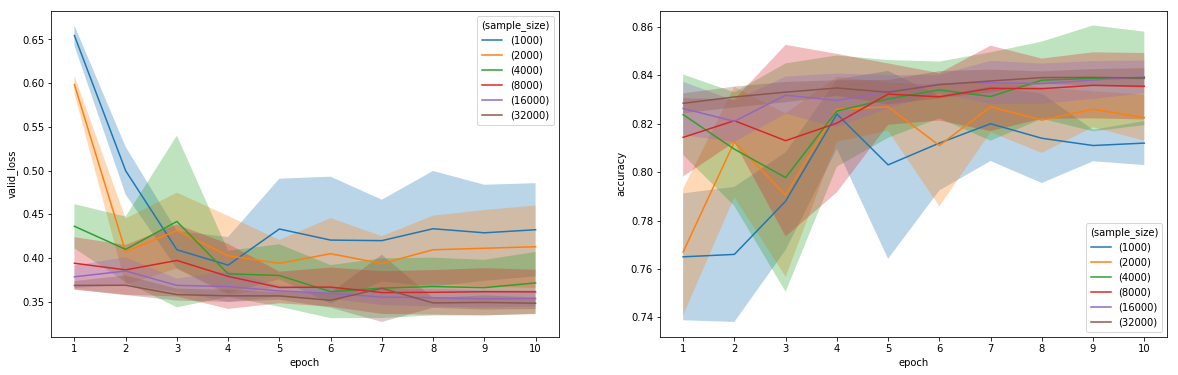

In [77]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Architecture Shape

In [91]:
arch_shapes={'constant':[1,1,1], 'increasing':[1,2,3], 'decreasing': [3,2,1], 'diamond':[1,2,1], 'hourglass':[2,1,2]}

In [157]:
def get_size_from_shape(shape, inp, out, n):
    x = sympy.Symbol('x')
    unit_size = int(sympy.solve([inp*shape[0]*x + shape[0]*x*shape[1]*x + shape[1]*x*shape[2]*x + shape[2]*x*out - n,x>0], x).rhs.evalf())
    return [s*unit_size for s in shape]

In [164]:
experiment_name, exp_path = create_experiment('shapes', path)

In [165]:
config={'shapes': ['constant', 'increasing', 'decreasing', 'diamond', 'hourglass'], 'n_params':[100000,1000000]}
config_df = get_config_df(config)

In [166]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [167]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=512))
        ls = get_size_from_shape(arch_shapes[params['shapes']], 69, data.c, params['n_params'])
        learn = tabular_learner(data, layers=ls, metrics=accuracy)
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss  accuracy
1      0.449254    0.335067    0.848280  (00:00)
2      0.365816    0.328142    0.847205  (00:00)
3      0.340478    0.317451    0.855498  (00:00)
4      0.329420    0.312177    0.858262  (00:00)
5      0.319721    0.307419    0.859951  (00:01)
6      0.315040    0.301318    0.863944  (00:01)
7      0.307955    0.307249    0.860258  (00:00)
8      0.299514    0.303715    0.863176  (00:01)
9      0.289772    0.302281    0.861947  (00:01)
10     0.281749    0.304539    0.862561  (00:00)



In [168]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

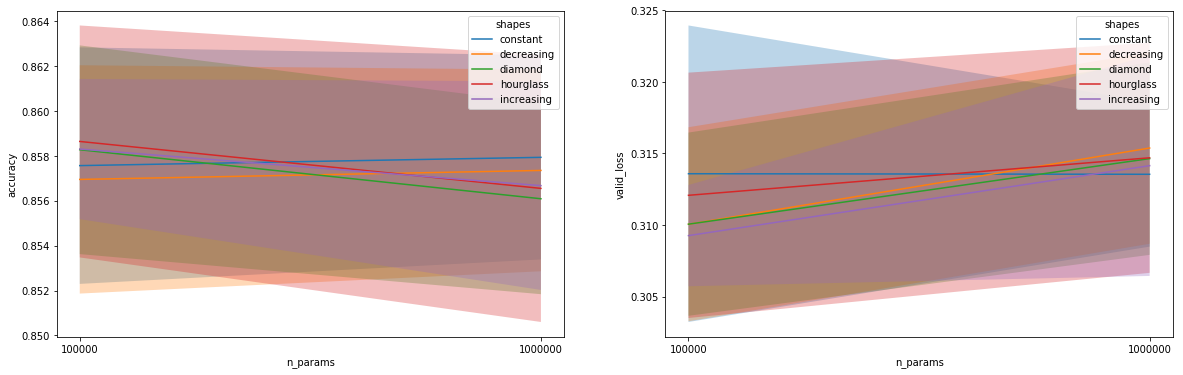

In [169]:
plot_best(summary_df, param_names[::-1], metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

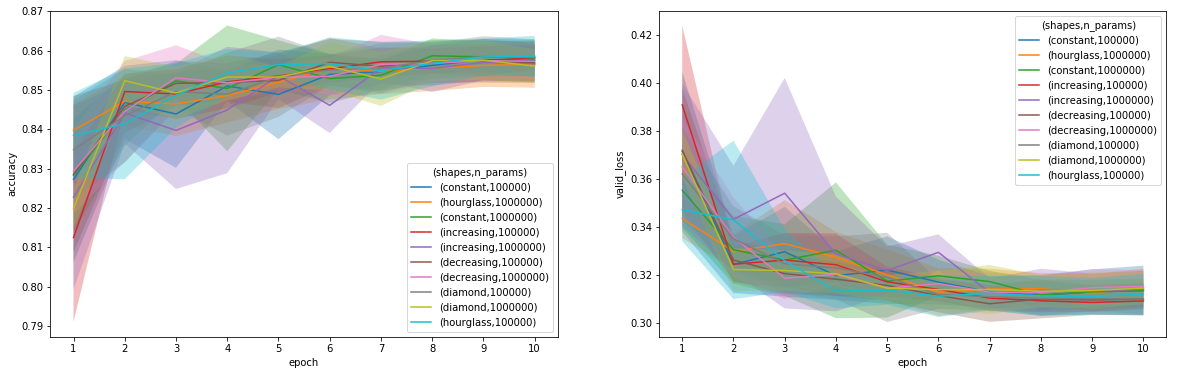

In [170]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# SeLU

In [44]:
experiment_name, exp_path = create_experiment('activation_depth', path)

In [45]:
config={'activation': ['relu', 'selu'], 'n_layer':[2,8]}
config_df = get_config_df(config)

In [46]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [47]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=512))

        learn = tabular_learner(data, layers=[256]*params['n_layer'], metrics=accuracy, act_func=params['activation'])
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss  accuracy
1      0.459412    0.411758    0.810657  (00:01)
2      0.372033    0.441079    0.801290  (00:01)
3      0.344902    0.319728    0.861026  (00:01)
4      0.329991    0.317390    0.843673  (00:01)
5      0.324363    0.329175    0.840141  (00:01)
6      0.319886    0.316330    0.848587  (00:01)
7      0.315048    0.329021    0.836302  (00:01)
8      0.311938    0.307750    0.860258  (00:01)
9      0.309102    0.303691    0.863944  (00:01)
10     0.305992    0.303915    0.864097  (00:01)



In [48]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

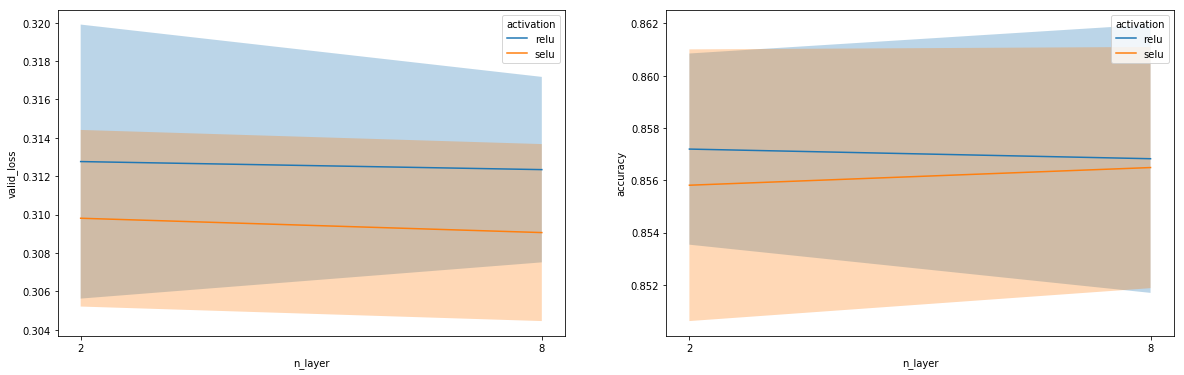

In [50]:
plot_best(summary_df, param_names[::-1], metric_names)
plt.savefig(exp_path/'best.png', bbox_inches='tight')

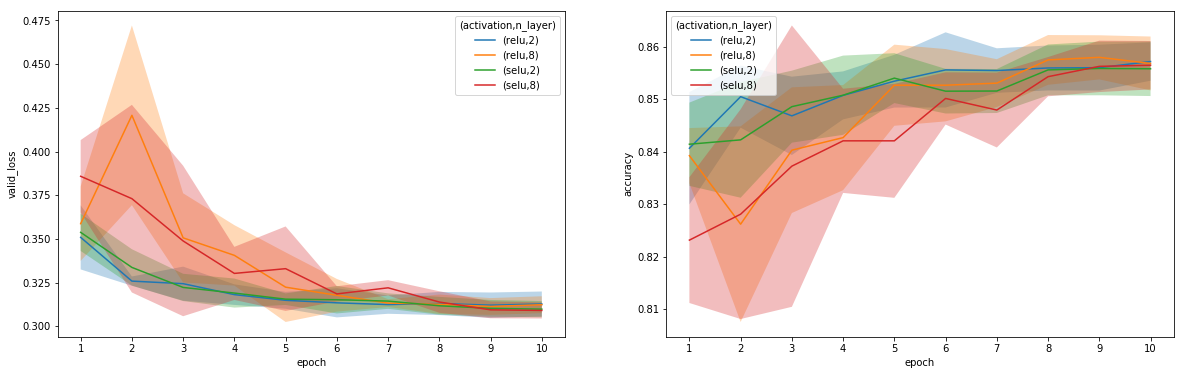

In [51]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Residual Connections

In [65]:
experiment_name, exp_path = create_experiment('residual_depth', path)

In [66]:
config={'residual': [False, True], 'n_layer':[2,6]}
config_df = get_config_df(config)

In [67]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [68]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=512))

        learn = tabular_learner(data, layers=[256]*params['n_layer'], metrics=accuracy, residual=params['residual'])
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss  accuracy
1      0.410156    0.359021    0.839681  (00:01)
2      0.349461    0.316514    0.859797  (00:01)
3      0.328878    0.316089    0.849662  (00:00)
4      0.318577    0.327770    0.847512  (00:00)
5      0.312033    0.304220    0.861947  (00:00)
6      0.308691    0.302314    0.865479  (00:00)
7      0.308414    0.312596    0.851812  (00:01)
8      0.299076    0.298585    0.867015  (00:01)
9      0.292695    0.298553    0.866708  (00:01)
10     0.288121    0.300187    0.866861  (00:00)



In [69]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

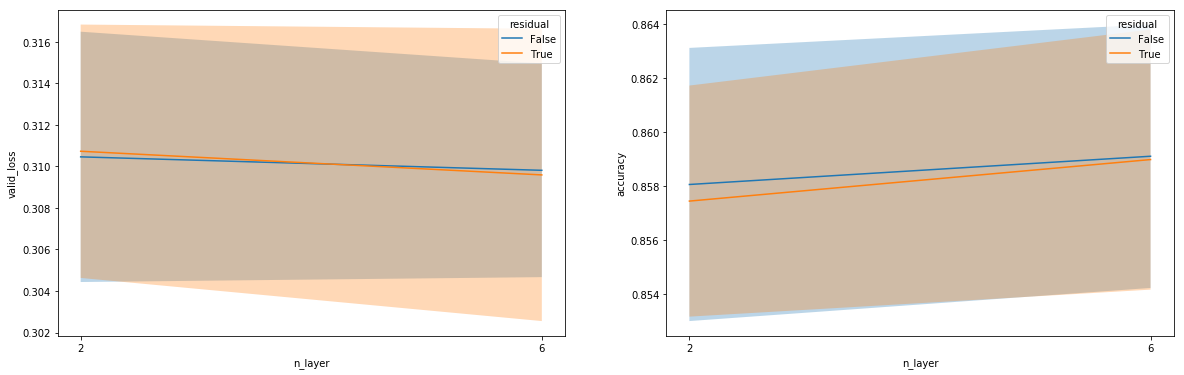

In [70]:
plot_best(summary_df, param_names[::-1], metric_names)#, ylim2=(0.8,0.86))
plt.savefig(exp_path/'best.png', bbox_inches='tight')

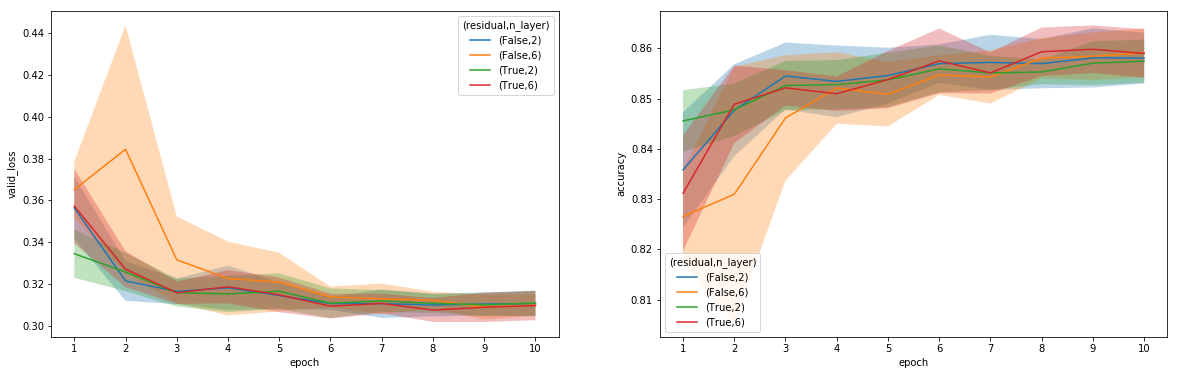

In [71]:
plot_over_epochs(summary_df, param_names, metric_names, config_df)#, ylim2=(0.8,0.86))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

# Attention

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# Augmentation Strategies

**Mixup**

In [17]:
experiment_name, exp_path = create_experiment('mixup_size', path)

In [18]:
config={'mixup': [0,0.1,0.2,0.3,0.4]}
config_df = get_config_df(config)

In [19]:
src = TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=num_vars, procs=procs)

In [20]:
config_df.to_csv(exp_path/'config.csv')
for i, params in config_df.iterrows():
    for fold, (train_ids, valid_ids) in enumerate(kf.split(df)):
        data = (src.split_by_idx(valid_ids)
                .label_from_df(cols=dep_var)
                .databunch(bs=256))

        learn = tabular_learner(data, layers=[256]*3, metrics=accuracy, mixup_alpha=params['mixup'])
        record_experiment(learn, f'{i}-fold_{fold+1}')
        learn.fit_one_cycle(10, 1e-2)

Total time: 00:59
epoch  train_loss  valid_loss  accuracy
1      0.387563    0.330247    0.851505  (00:05)
2      0.334846    0.321554    0.849816  (00:05)
3      0.330707    0.311913    0.854576  (00:05)
4      0.326760    0.313327    0.856112  (00:05)
5      0.325932    0.329956    0.837224  (00:06)
6      0.316840    0.309566    0.856419  (00:06)
7      0.313521    0.310937    0.855344  (00:05)
8      0.306872    0.305561    0.862869  (00:05)
9      0.297367    0.305772    0.861947  (00:05)
10     0.297259    0.306731    0.862715  (00:06)



epoch,train_loss,valid_loss,accuracy


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [28]:
config_df, recorder_df, param_names, metric_names = load_results(exp_path)
summary_df = summarise_results(recorder_df, param_names, metric_names)

In [172]:
# plot_best(summary_df, param_names[::-1], metric_names)#, ylim2=(0.8,0.86))
# plt.savefig(exp_path/'best.png', bbox_inches='tight')

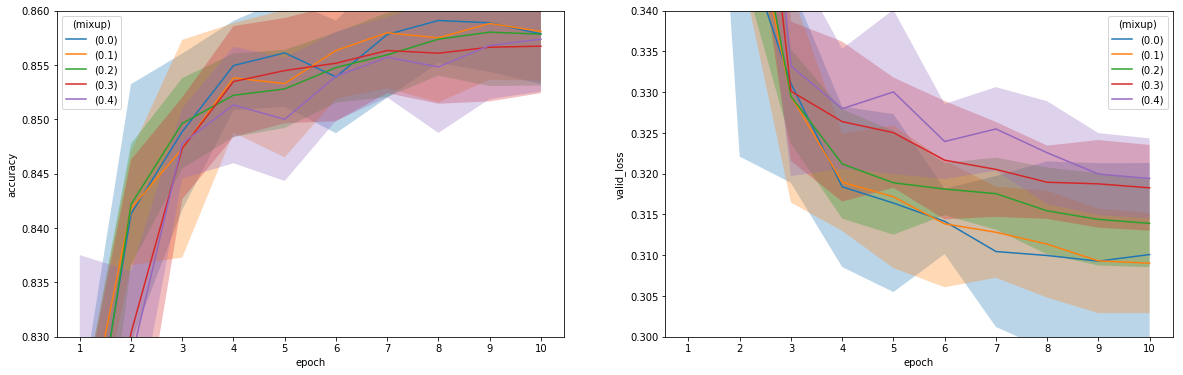

In [36]:
plot_over_epochs(summary_df, param_names, metric_names, config_df, ylim1=(0.83,0.86), ylim2=(0.3,0.34))
plt.savefig(exp_path/'all_epochs.png', bbox_inches='tight')

**Swap Noise**

In [23]:
(tmp_cats, tmp_conts), _ = next(iter(data.train_dl))

In [24]:
tmp_cats

tensor([[ 3,  2,  6,  ...,  2, 39,  1],
        [ 8,  9,  5,  ...,  1, 39,  1],
        [ 5, 13,  3,  ...,  2, 30,  1],
        ...,
        [ 5, 10,  5,  ...,  2, 39,  1],
        [ 8, 11,  3,  ...,  2, 39,  1],
        [ 7, 16,  3,  ...,  2, 39,  1]])

In [25]:
tmp_conts

tensor([[-0.3350,  0.5147, -1.1988, -0.1473, -0.2155, -0.0310],
        [-1.1393,  1.1011,  0.3650, -0.1473, -0.2155, -0.0310],
        [ 0.5425, -0.4986,  1.5377, -0.1473, -0.2155, -0.0310],
        ...,
        [-0.6274,  0.3449,  1.1468, -0.1473, -0.2155, -0.0310],
        [ 0.1038, -0.9785,  2.3196, -0.1473, -0.2155,  0.7782],
        [-0.5543, -1.0429, -0.0260, -0.1473, -0.2155, -0.0310]])

In [140]:
shuffle_conts = torch.cat(
    [tmp_conts[torch.randperm(tmp_conts.shape[0]).to(tmp_conts.device), col].view(-1,1) for col in range(tmp_conts.shape[1])], 1)

In [154]:
shuffle_conts + tmp_conts

tensor([[-1.5474,  0.2006, -1.2247, -0.2945, -0.4311, -1.6803],
        [-2.2054, -0.1382, -0.0520, -0.2945, -0.4311, -0.0619],
        [-0.3043,  1.2350,  1.5118, -0.2945, -0.4311, -0.0619],
        ...,
        [-2.1323, -0.4954,  1.1208, -0.2945, -0.4311, -0.4665],
        [-0.0119,  0.1317,  1.9027, -0.2945, -0.4311,  0.7473],
        [-1.9861, -1.0870,  0.3390, -0.2945, -0.4311, -0.0619]])

In [182]:
lambd=np.random.binomial(1, 0.1, tmp_conts.shape)

In [184]:
lambd = tmp_conts.new(lambd)

In [186]:
tmp_conts*(1-lambd) + shuffle_conts*lambd

tensor([[-1.2124,  0.5147, -1.1988, -0.1473, -0.2155, -0.0310],
        [-1.1393,  1.1011,  0.3650, -0.1473, -0.2155, -0.0310],
        [ 0.5425, -0.4986,  1.5377, -0.1473, -0.2155, -0.0310],
        ...,
        [-0.6274,  0.3449,  1.1468, -0.1473, -0.2155, -0.0310],
        [ 0.1038, -0.9785,  2.3196, -0.1473, -0.2155,  0.7782],
        [-0.5543, -1.0429, -0.0260, -0.1473, -0.2155, -0.0310]])

# Pretraining

## Process categoricals

**Note**: missing values are not yet treated

In [12]:
categories={}
for col in cat_vars:
    train_df.loc[:, col] = train_df.loc[:, col].astype('category').cat.as_ordered()
    categories.update({col:train_df.loc[:, col].cat.categories.values})
    test_df.loc[:, col] = pd.Categorical(test_df.loc[:, col], categories=categories[col], ordered=True)

still need to choose how to represent them, either one-hot or integer encoded

One-hot encode

In [13]:
for col in cat_vars:
    train_df = train_df.drop(columns=col).join(pd.get_dummies(train_df.loc[:,col], prefix=col))
    test_df = test_df.drop(columns=col).join(pd.get_dummies(test_df.loc[:,col], prefix=col))

In [14]:
train_df.head()

,age,fnlwgt,>=50k,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,45,167523,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,44,126199,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,55,37438,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,34,143766,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,46,167159,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Process numerics

In [15]:
for col in num_vars:
    train_df.loc[:, col] = train_df[col].astype(np.float32)
    test_df.loc[:, col] = test_df[col].astype(np.float32)

### Choose normalisation

Standard 0 mean and unit variance scaling

In [16]:
stats={}
for col in num_vars:
    stats.update({col: np.array([train_df[col].mean(), train_df[col].std()])})
    train_df.loc[:,col] = (train_df[col]-stats[col][0])/stats[col][1]
    test_df.loc[:,col] = (test_df[col]-stats[col][0])/stats[col][1]

In [17]:
stats

{'age': array([38.588524, 13.686339]),
 'fnlwgt': array([189604.40625 , 104962.476562])}

## Dataset

In [18]:
class TabularDataset(Dataset):
    def __init__(self, df, dep_var):
        self.x = df.drop(columns=dep_var).values
        self.y = df[dep_var].values
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.get_x(idx)
        y = self.get_x(idx)
        return (x, y)
    
    def get_x(self, idx):
        return torch.tensor(self.x[idx,:], dtype=torch.float32)
    
    def get_y(self, idx):
        return torch.tensor(self.y[idx], dtype=torch.int64)

In [19]:
train_ds = TabularDataset(train_df, dep_var)
test_ds = TabularDataset(test_df, dep_var)

## Data loader

In [20]:
bs=64

In [21]:
train_dl = DataLoader(train_ds, batch_size=bs)
test_dl = DataLoader(test_ds, batch_size=bs)

In [22]:
x, y = next(iter(train_dl))

In [24]:
print(x.shape, y.shape)

torch.Size([64, 60]) torch.Size([64, 60])


In [25]:
data = DataBunch(train_dl, test_dl)

# Model

In [95]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 2]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [43]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        sizes = [60, 200, 200, 60]
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,act) in enumerate(zip(sizes[:-1],sizes[1:],actns)):
            layers += bn_drop_lin(n_in, n_out, bn=False, p=0, actn=act)
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [44]:
m = DAE()

In [45]:
m

DAE(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=200, out_features=60, bias=True)
  )
)

In [46]:
x_batch, y_batch = next(iter(train_dl))

In [47]:
m(x_batch).shape

torch.Size([64, 60])

In [48]:
learn = Learner(data, m, metrics=None, loss_func=F.mse_loss)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


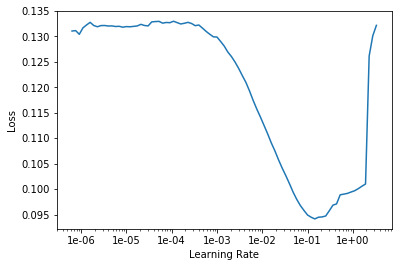

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(3, 1e-2)

Total time: 00:10
epoch  train_loss  valid_loss
1      0.003137    0.003181    (00:03)
2      0.000648    0.000430    (00:03)
3      0.000052    0.000055    (00:03)

